# Divvy Bike Share – Exploratory Data Analysis (EDA)

## Project Context
This notebook performs an exploratory data analysis (EDA) on the Divvy Bike Share dataset.
The goal is to understand usage patterns, rider behavior, and operational characteristics
to support the design of a real-time data engineering pipeline using Kafka, Spark,
PostgreSQL, and Streamlit.

Due to the large size of the dataset, a controlled sampling strategy is applied
to ensure memory efficiency and reproducibility.

## Necessary Modules

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from math import radians, cos, sin, asin, sqrt

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

## Dataset Loading

In [9]:
files = glob.glob("../data/*.csv")

ROWS_PER_FILE = 10_000
dfs = []

for file in files:
    df_part = pd.read_csv(file, nrows=ROWS_PER_FILE)
    dfs.append(df_part)

df = pd.concat(dfs, ignore_index=True)

df.shape


(983938, 51)

## Inspect Data

In [10]:
df.info()
df.describe(include="all").T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983938 entries, 0 to 983937
Data columns (total 51 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   ride_id                                           690000 non-null  object 
 1   rideable_type                                     690000 non-null  object 
 2   started_at                                        690000 non-null  object 
 3   ended_at                                          690000 non-null  object 
 4   start_station_name                                511829 non-null  object 
 5   start_station_id                                  511751 non-null  object 
 6   end_station_name                                  503391 non-null  object 
 7   end_station_id                                    503335 non-null  object 
 8   start_lat                                         690000 non-null  float64
 9   star

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ride_id,690000,690000,A847FADBBC638E45,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rideable_type,690000,4,electric_bike,378272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
started_at,690000,687899,2021-09-15 18:19:52,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ended_at,690000,687847,2024-12-16 10:44:24.347,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_station_name,511829,1564,Desplaines St & Kinzie St,4521,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_station_id,511751,2978,TA1306000003,3711,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_station_name,503391,1540,Kingsbury St & Kinzie St,7467,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_station_id,503335,2938,KA1503000043,6408,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_lat,690000.0,NaN,NaN,NaN,41.902111,0.049572,41.64,41.88,41.9,41.93,42.07
start_lng,690000.0,NaN,NaN,NaN,-87.649543,0.030858,-87.86,-87.665854,-87.645451,-87.63,-87.52


## Data Cleaning and Feature Engineering

This step ensures correct data types and creates features
needed for temporal and behavioral analysis.

In [11]:
df["started_at"] = pd.to_datetime(df["started_at"], errors="coerce", format="mixed")
df["ended_at"] = pd.to_datetime(df["ended_at"], errors="coerce", format="mixed")

df = df.dropna(subset=["started_at", "ended_at"])

## Feature Engineering

In [12]:
df["trip_duration_min"] = (
    df["ended_at"] - df["started_at"]
).dt.total_seconds() / 60

df = df[df["trip_duration_min"] > 0]

df["hour"] = df["started_at"].dt.hour
df["weekday"] = df["started_at"].dt.day_name()
df["month"] = df["started_at"].dt.month
df["is_weekend"] = df["weekday"].isin(["Saturday", "Sunday"])

## Trip Duration Distribution

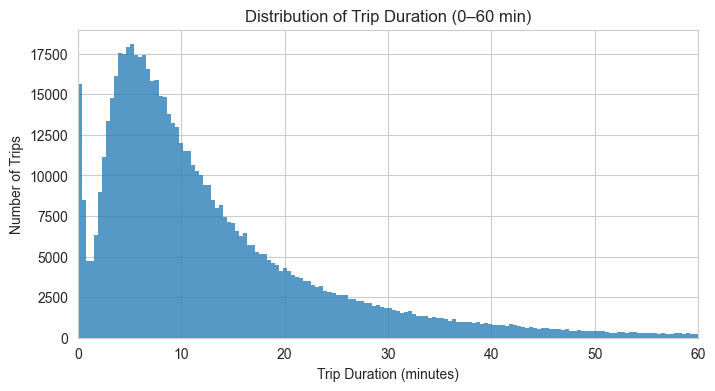

In [30]:
plt.figure(figsize=(8,4))
sns.histplot(df["trip_duration_min"], bins=100000)
plt.xlim(0, 60)
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Number of Trips")
plt.title("Distribution of Trip Duration (0–60 min)")
plt.show()

- Most trips are short, typically under 20 minutes.
- The distribution is strongly right-skewed, with a small number of long trips.
- This pattern is characteristic of urban bike-sharing systems.

## Trip Duration by Rider Type

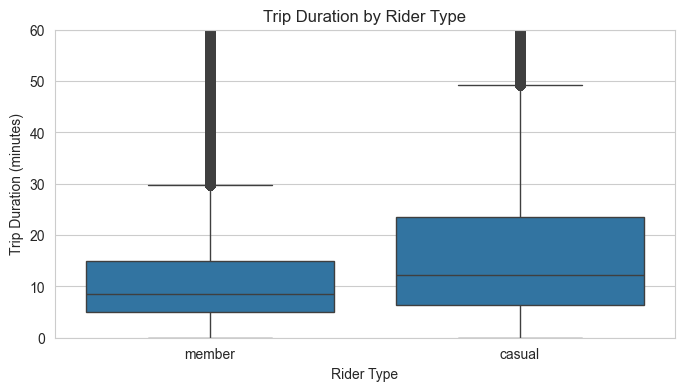

In [31]:
plt.figure(figsize=(8,4))
sns.boxplot(x="member_casual", y="trip_duration_min", data=df)
plt.ylim(0, 60)
plt.xlabel("Rider Type")
plt.ylabel("Trip Duration (minutes)")
plt.title("Trip Duration by Rider Type")
plt.show()

- Casual riders tend to take longer trips than members.
- Members show more consistent and shorter trip durations, suggesting commuting-oriented usage.

## Hourly Usage Pattern

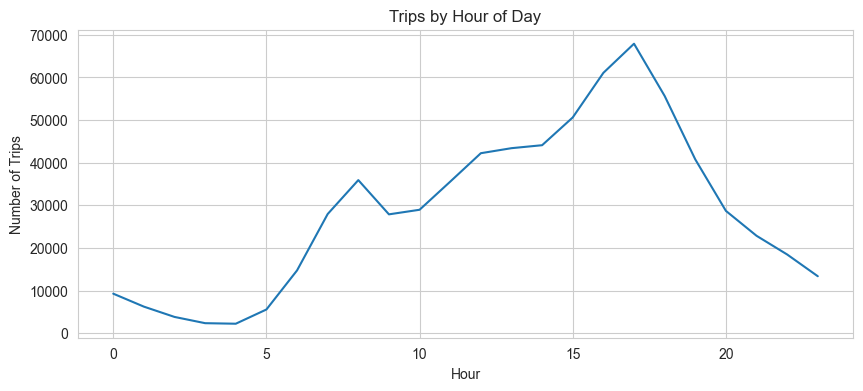

In [15]:
hourly = df.groupby("hour").size()

plt.figure(figsize=(10,4))
hourly.plot()
plt.title("Trips by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Trips")
plt.show()

Two clear peaks appear in the morning and evening hours,
indicating strong commuting behavior.

## Weekday Usage

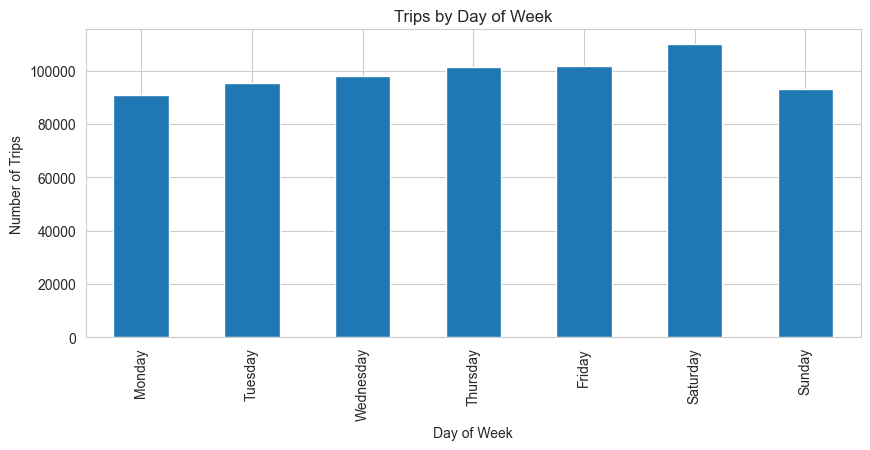

In [32]:
weekday_counts = df.groupby("weekday").size().reindex([
    "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"
])

plt.figure(figsize=(10,4))
weekday_counts.plot(kind="bar")
plt.xlabel("Day of Week")
plt.ylabel("Number of Trips")
plt.title("Trips by Day of Week")
plt.show()

## Weekend vs Weekday by Rider Type

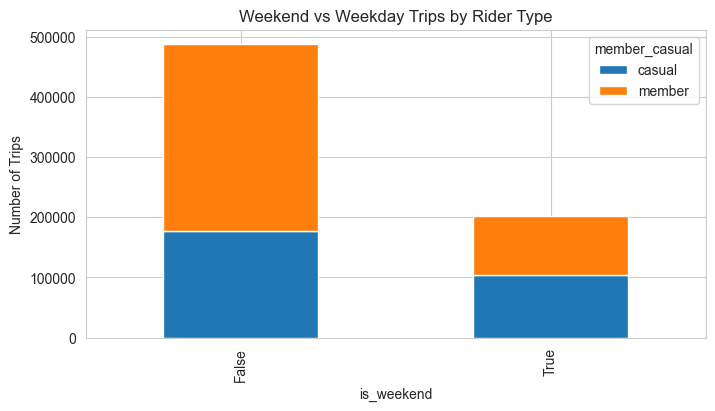

In [33]:
weekend_table = df.groupby(["is_weekend", "member_casual"]).size().unstack()

weekend_table.plot(kind="bar", stacked=True, figsize=(8,4))
plt.ylabel("Number of Trips")
plt.title("Weekend vs Weekday Trips by Rider Type")
plt.show()

Casual riders dominate weekend usage, while members ride more consistently
throughout the week. This highlights distinct user personas.

## Monthly Seasonality

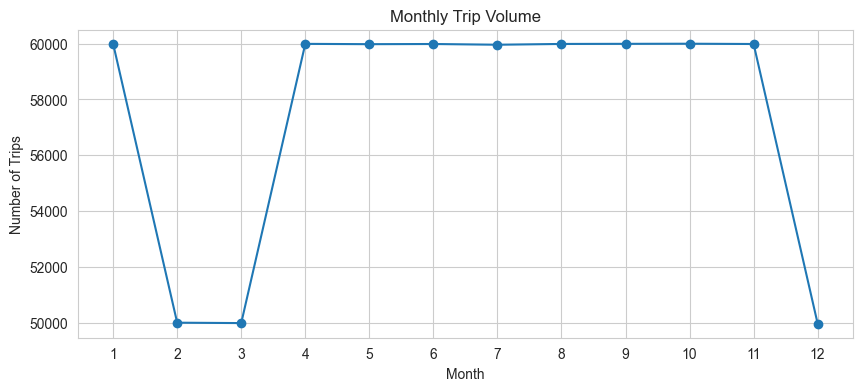

In [34]:
monthly = df.groupby("month").size()

plt.figure(figsize=(10,4))
monthly.plot(marker="o")
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.title("Monthly Trip Volume")
plt.show()

Bike usage increases significantly during warmer months
and declines during winter, reflecting weather dependence.

## Bike Type Usage

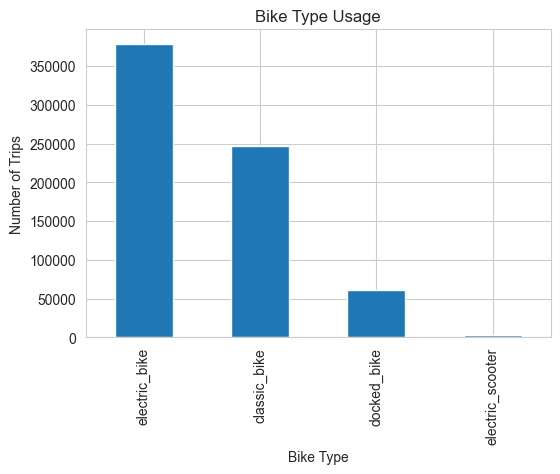

In [35]:
plt.figure(figsize=(6,4))
df["rideable_type"].value_counts().plot(kind="bar")
plt.xlabel("Bike Type")
plt.ylabel("Number of Trips")
plt.title("Bike Type Usage")
plt.show()

## Trip Distance Estimation

In [36]:
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return 6371 * c

geo_df = df.dropna(subset=["start_lat","start_lng","end_lat","end_lng"]).sample(50_000)

geo_df["trip_distance_km"] = geo_df.apply(
    lambda r: haversine(r.start_lat, r.start_lng, r.end_lat, r.end_lng),
    axis=1
)

## Trip Distance Distribution

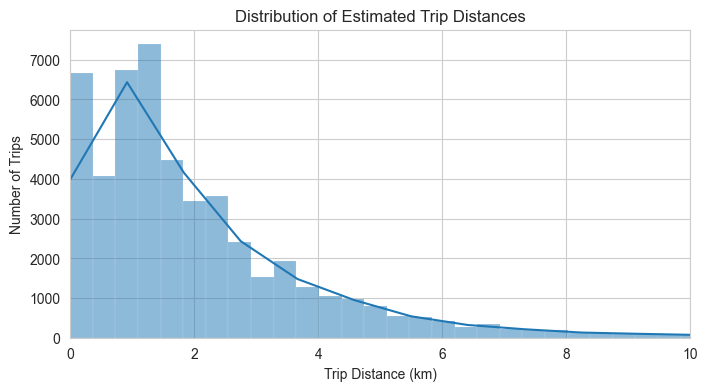

In [39]:
plt.figure(figsize=(8,4))
sns.histplot(geo_df["trip_distance_km"], bins=500, kde=True)
plt.xlim(0, 10)
plt.xlabel("Trip Distance (km)")
plt.ylabel("Number of Trips")
plt.title("Distribution of Estimated Trip Distances")
plt.show()

## Distance by Rider Type

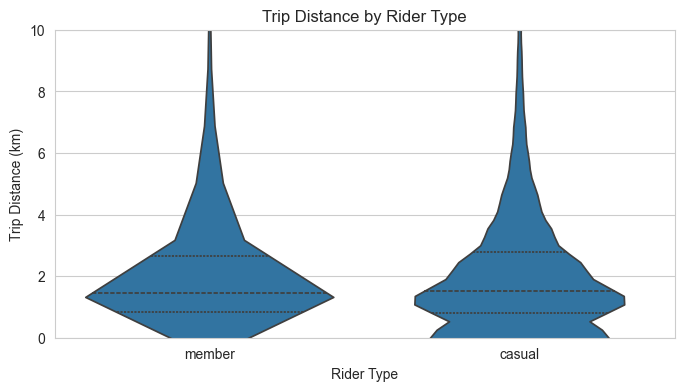

In [40]:
plt.figure(figsize=(8,4))
sns.violinplot(
    x="member_casual",
    y="trip_distance_km",
    data=geo_df,
    inner="quartile"
)
plt.ylim(0, 10)
plt.xlabel("Rider Type")
plt.ylabel("Trip Distance (km)")
plt.title("Trip Distance by Rider Type")
plt.show()

## Trip Distance vs Duration

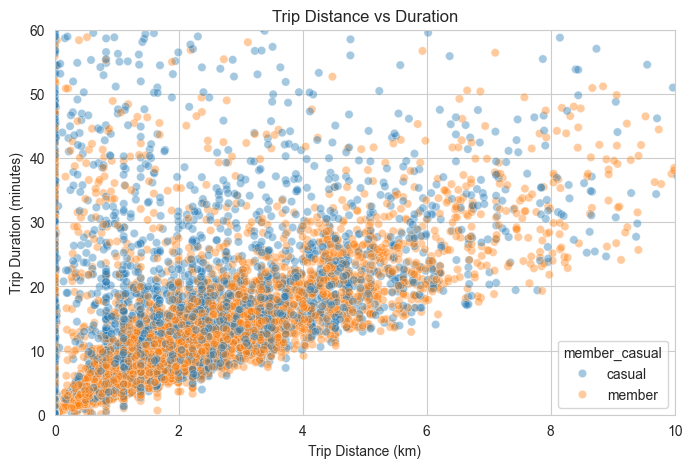

In [24]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=geo_df.sample(10_000),
    x="trip_distance_km",
    y="trip_duration_min",
    hue="member_casual",
    alpha=0.4
)

plt.xlim(0, 10)
plt.ylim(0, 60)
plt.xlabel("Trip Distance (km)")
plt.ylabel("Trip Duration (minutes)")
plt.title("Trip Distance vs Duration")
plt.show()

## Average Speed Analysis

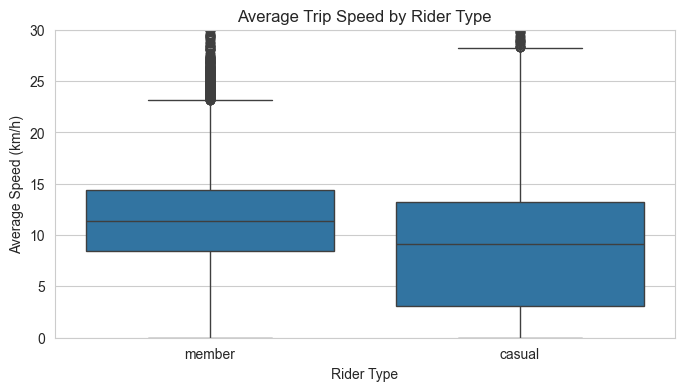

In [41]:
geo_df["avg_speed_kmh"] = geo_df["trip_distance_km"] / (geo_df["trip_duration_min"] / 60)

plt.figure(figsize=(8,4))
sns.boxplot(x="member_casual", y="avg_speed_kmh", data=geo_df)
plt.ylim(0, 30)
plt.xlabel("Rider Type")
plt.ylabel("Average Speed (km/h)")
plt.title("Average Trip Speed by Rider Type")
plt.show()

- Trips are predominantly short-distance.
- Members ride faster and more consistently, while casual riders exhibit greater variability in distance and speed, reflecting leisure use.

## Station Popularity

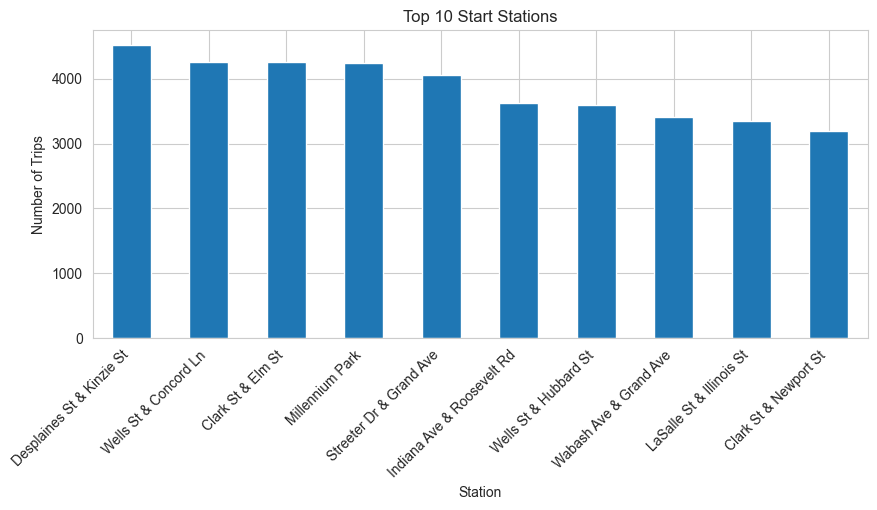

In [42]:
top_stations = df["start_station_name"].value_counts().head(10)

plt.figure(figsize=(10,4))
top_stations.plot(kind="bar")
plt.xlabel("Station")
plt.ylabel("Number of Trips")
plt.title("Top 10 Start Stations")
plt.xticks(rotation=45, ha="right")
plt.show()

## Station Imbalance

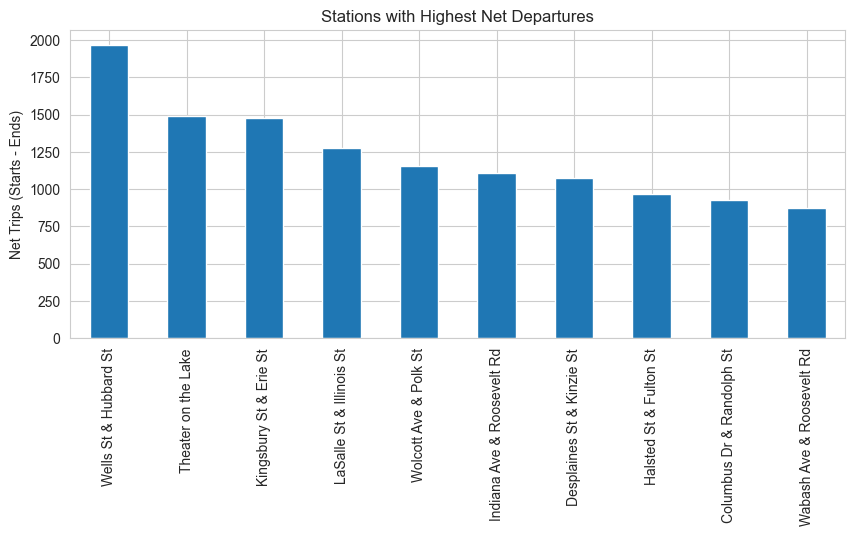

In [43]:
station_balance = (
    df["start_station_name"].value_counts()
    - df["end_station_name"].value_counts()
).dropna()

station_balance.sort_values(ascending=False).head(10).plot(
    kind="bar", figsize=(10,4)
)
plt.ylabel("Net Trips (Starts - Ends)")
plt.title("Stations with Highest Net Departures")
plt.show()

## Key KPIs for Real-Time Processing

Based on this EDA, the following KPIs are selected:
- Trips per hour
- Average trip duration
- Member vs casual ratio
- Average speed
- Top active stations
- Weekend vs weekday usage

These KPIs will be computed using Spark Structured Streaming
and visualized in a Streamlit dashboard.